In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
import sklearn

In [2]:
print(sklearn.__version__)

0.24.1


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')
tf.config.experimental.set_memory_growth(device=gpus[0], enable=True)

In [4]:
data = pd.read_csv('stoch_corr_arctan_1000.csv', header=None)

C:\Users\danci\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
observations = data.iloc[:100000, 1:1000]
paramsets = data.iloc[:100000, 1001:1002]

In [6]:
params_reshape = np.array(paramsets).reshape(100000, 1, 1)
one_sample_reshape = np.array(observations).reshape(100000,1,999)

In [7]:
print(params_reshape.shape, one_sample_reshape.shape)

(100000, 1, 1) (100000, 1, 999)


In [8]:
tf.keras.backend.clear_session()
tf.keras.backend.set_floatx('float64')

model = tf.keras.Sequential()
model.add(layer=tf.keras.layers.Dense(units=30, activation=tf.keras.activations.elu, input_shape=(1, 999)))
model.add(layer=tf.keras.layers.Dense(units=30, activation=tf.keras.activations.elu))
model.add(layer=tf.keras.layers.Dense(units=30, activation=tf.keras.activations.elu))
model.add(layer=tf.keras.layers.Dense(units=1, activation=tf.keras.activations.tanh))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 30)             30000     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 30)             930       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 30)             930       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              31        
Total params: 31,891
Trainable params: 31,891
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(
    optimizer="adam",
    loss='mse',
)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5)

history = model.fit(x=one_sample_reshape, y=params_reshape, epochs=25, validation_split=0.20, batch_size=32, verbose=1, callbacks=[callback])

Epoch 1/25
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0148 - val_loss: 0.0022
Epoch 2/25
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0021 - val_loss: 0.0028
Epoch 3/25
2500/2500 [==============================] - 15s 6ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 4/25
2500/2500 [==============================] - 14s 5ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 5/25
2500/2500 [==============================] - 14s 6ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/25
2500/2500 [==============================] - 22s 9ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 7/25
2500/2500 [==============================] - 30s 12ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 8/25
2500/2500 [==============================] - 33s 13ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/25
2500/2500 [==============================] - 34s 13ms/step - loss: 0.0013 - val_loss: 0.0015


In [31]:
simulated = []
predicted = []

append_index = 0
start = 90000

for i in tqdm(range(start, start + 500, 1)):
    test_input = one_sample_reshape[i]
    test_input_1 = test_input.reshape(1, 1, 999)
    test_output = model.predict(test_input_1, verbose=0)
    # if np.linalg.norm(params_reshape[i][0][0]-test_output[0][0]) <= 0.10:
        # append_index = append_index + 1
        # print(f'appended: {append_index}')
    predicted.append(test_output[0][0])
    simulated.append(params_reshape[i][0][0])
    # else:
    #     None
    
    print(test_output, params_reshape[i])

  1%|          | 4/500 [00:00<00:25, 19.14it/s][[[0.21752684]]] [[0.20223853]]
[[[-0.54615213]]] [[-0.53746658]]
[[[-0.21160992]]] [[-0.21964522]]
[[[-0.13174705]]] [[-0.11013448]]
  2%|▏         | 9/500 [00:00<00:24, 19.87it/s] [[0.23275889]]
[[[0.32547554]]] [[0.28487166]]
[[[-0.15592257]]] [[-0.15671031]]
[[[-0.77178881]]] [[-0.70649944]]
[[[-0.94011052]]] [[-0.97969495]]
  2%|▏         | 11/500 [00:00<00:24, 19.91it/s][[[-0.07428752]]] [[-0.06708767]]
[[[-0.49038902]]] [[-0.5013236]]
[[[0.51903996]]] [[0.48470156]]
[[[0.75932507]]] [[0.74106133]]
  3%|▎         | 17/500 [00:00<00:23, 20.43it/s] [[-0.79790541]]
[[[-0.18558757]]] [[-0.14854204]]
[[[-0.4796504]]] [[-0.42756642]]
[[[-0.33989753]]] [[-0.35282052]]
  4%|▍         | 21/500 [00:01<00:24, 19.30it/s] [[-0.94494085]]
[[[-0.31338846]]] [[-0.29300013]]
[[[-0.33528106]]] [[-0.35440299]]
[[[0.62849382]]] [[0.68134703]]
  5%|▍         | 23/500 [00:01<00:25, 18.63it/s][[[-0.91742938]]] [[-0.86259947]]
[[[-0.69014537]]] [[-0.7322977

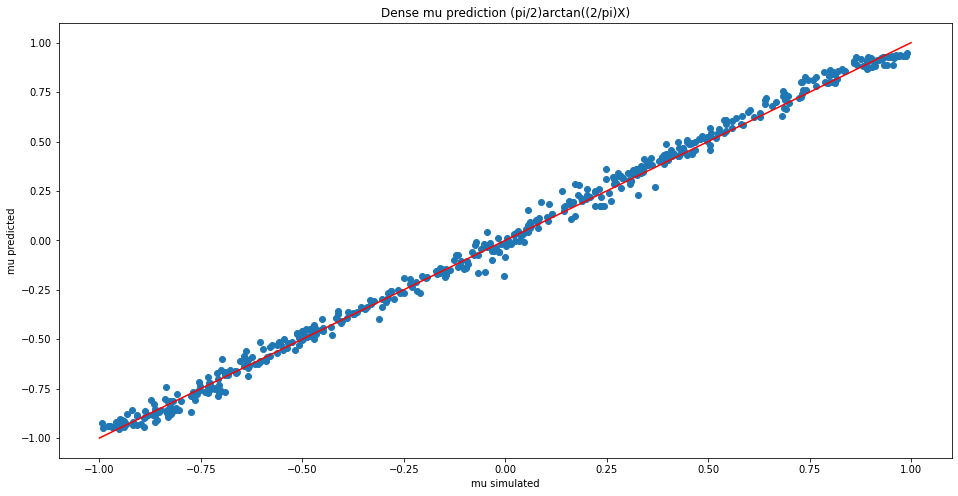

In [32]:
plt.figure(figsize=(16,8))
plt.plot([-1,1], [-1,1], 'red')
plt.scatter(simulated, predicted)
plt.xlabel('mu simulated')
plt.ylabel('mu predicted')
plt.title('Dense mu prediction (pi/2)arctan((2/pi)X)')
plt.show()

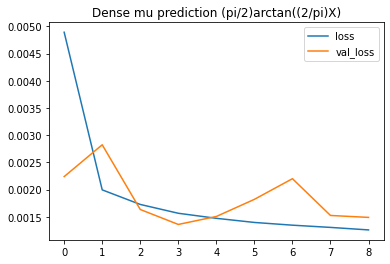

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense mu prediction (pi/2)arctan((2/pi)X)')
plt.legend(['loss', 'val_loss'])
plt.show()

In [51]:
data = np.array([predicted, np.array(simulated).reshape(500, 1)]).reshape(2, 500)
pd.DataFrame(data).transpose().to_excel('arctan_dense_mu_v1_preds.xlsx')